# Analise de aluguel de imoveis São Paulo


## Importando Libs


In [2]:
import pandas as pd
import time
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

## Carregamento dos Dataset


In [3]:
df = pd.read_csv('/home/llmdom/tes/data.csv')
df.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


## Analise de Dados


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [5]:
df.describe()

,area,bedrooms,garage,rent,total
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625
std,74.020536,0.931313,1.132349,2650.711557,3352.480274
min,0.000000,0.000000,0.000000,500.000000,509.000000
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000
max,580.000000,6.000000,6.000000,25000.000000,28700.000000


In [6]:
df.isnull().sum()

address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64

## Visualização de Dados


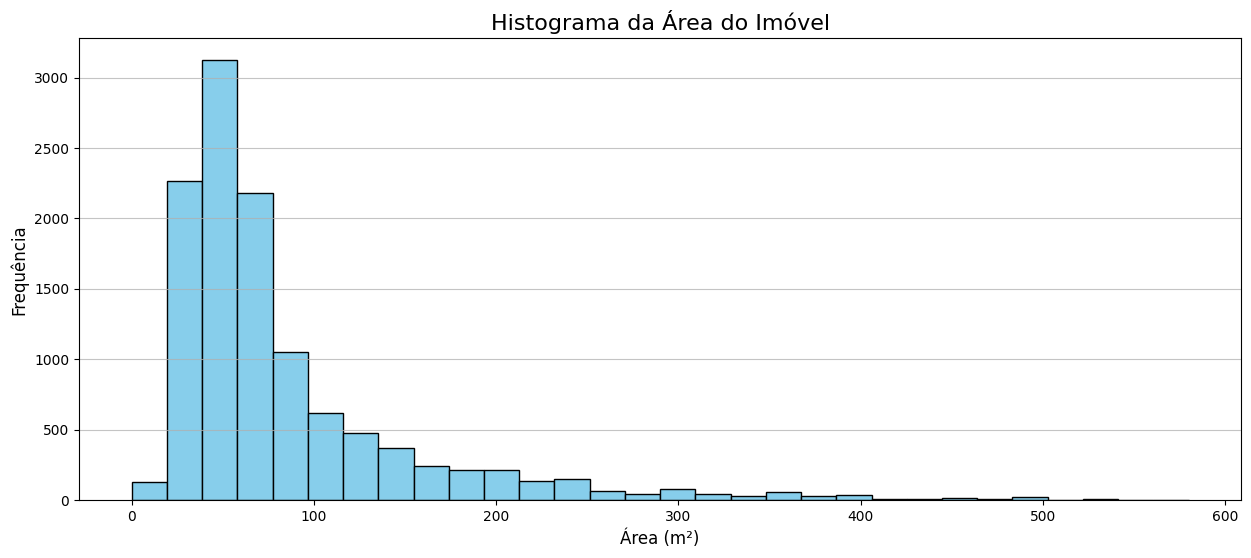

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.hist(df.area, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Histograma da Área do Imóvel', fontsize=16)
ax.set_xlabel('Área (m²)', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(axis='y', alpha=0.75)

count    11657.000000
mean        84.655658
std         74.020536
min          0.000000
25%         40.000000
50%         60.000000
75%         96.000000
max        580.000000
Name: area, dtype: float64

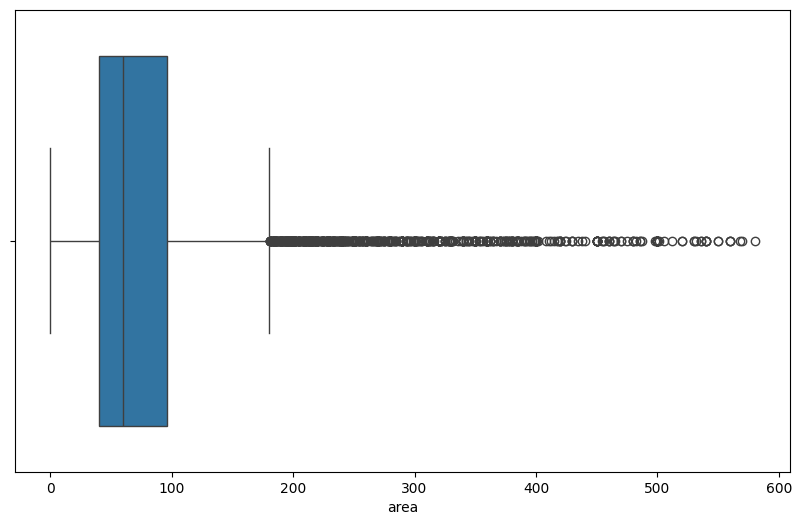

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

#### Area com menor valor de aluguel


In [9]:
df[df.rent == 500]

,address,district,area,bedrooms,garage,type,rent,total
51,Rua Tanque Velho,Vila Nivi,45,1,0,Casa,500,551
1188,Viela Renaldo Laporta,Vila Aurora (zona Norte),30,1,0,Casa,500,521
4741,Rua Manoel Oliveira Gonçalves,Jardim Jaçanã,30,1,0,Casa,500,509
5901,Rua Manuel José Rodrigues,Sacoma,40,1,0,Casa,500,521
6428,Rua Eugênia S Vitale,Taboão,30,1,0,Studio e kitnet,500,594
7420,Rua Manuel José Rodrigues,Sacoma,20,1,0,Casa,500,521
10559,Rua Arraial de São Bartolomeu,Vila Carmosina,70,2,0,Casa,500,821


## Limpeza de Dados


In [10]:
# Normaliza os nomes dos bairros para padronização
df['district'] = df['district'].str.lower().str.strip()
# Mapeamento manual de variações para nomes oficiais.
# Adicione mais mapeamentos aqui conforme necessário.
mapeamento_nomes = {
    'vila aricanduva': 'Aricanduva',
    'jardim aricanduva': 'Aricanduva',
    'agua branca': 'Água Branca',
    'agua fria': 'Água Fria',
    'agua rasa': 'Água Rasa',
    'bras': 'Brás',
    'santa cecilia': 'Santa Cecília',
    'santa ifigenia': 'Santa Efigênia',
    'chacara santo antonio (zona sul)': 'Chácara Santo Antônio',
    'chacara santo antonio (zona leste)': 'Chácara Santo Antônio',
    'jardim santa cruz (campo grande)': 'Campo Grande',
    'jardim sao paulo(zona norte)': 'Jardim São Paulo',
    'parque são lucas': 'São Lucas',
    'parque da vila prudente': 'Vila Prudente',
    'vila sonia': 'Vila Sônia',
    'bosque da saude': 'Saúde',
    'vila da saude': 'Saúde',
    'jardim da saude': 'Saúde',
    'parque jabaquara': 'Jabaquara',
    'vila parque jabaquara': 'Jabaquara',
    'jardim jabaquara': 'Jabaquara',
    'jardim analia franco': 'Jardim Anália Franco',
    'vila pompéia': 'Pompéia',
    'varzea da barra funda': 'Barra Funda',
    'lapa de baixo': 'Lapa',
    'parque da lapa': 'Lapa',
    'parque residencial da lapa': 'Lapa',
    'jardim das perdizes': 'Perdizes',
    'saco ma': 'Sacomã',
    'jardim vergueiro (sacomã)': 'Sacdf[df.rent == 500]omã',
    'jardim santa cruz (sacomã)': 'Sacomã',
    'vila matiilde': 'Vila Matilde',
    'centro capital': 'Centro',
    'vila brasilandia': 'Brasilândia',
    'vila pirituba': 'Pirituba',
    'jardim cidade pirituba': 'Pirituba',
    'jardim pirituba': 'Pirituba',
    'republica': 'República',
    'jardim rio pequeno': 'Rio Pequeno',
    'parque da mooca': 'Mooca',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'vila brasilandia': 'Brasilândia',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'nossa senhora do ó': 'Freguesia do Ó',
    'nossa senhora do o': 'Freguesia do Ó',
    'penha de frança': 'Penha',
    'jardim penha': 'Penha',
    'jardim america da penha': 'Penha',
    'jardim paulistano': 'Jardim Paulista',
    'jardim peri peri': 'Jardim Peri',
    'vila são josé (ipiranga)': 'Ipiranga',
    'vila maria alta': 'Vila Maria',
    'vila maria baixa': 'Vila Maria',
    'jardim vila mariana': 'Vila Mariana',
    'panamby': 'Panamby',
    'super quadra morumbi': 'Morumbi',
    'recanto morumbi': 'Morumbi',
    'jardim parque morumbi': 'Morumbi',
    'parque bairro morumbi': 'Morumbi',
    'jardim independencia (são paulo)': 'Jardim Independência',
    'jardim panaroma (zona leste)': 'Jardim América',
    'brooklin novo': 'Brooklin',
    'brooklin paulista': 'Brooklin',
}

# Aplica o mapeamento para criar a coluna de bairro oficial
df['district'] = df['district'].apply(
    lambda x: mapeamento_nomes.get(x, x.title())
)

### Tratando os outliers


Consideramos imóveis entre 40m² e 90m², pois refletem o padrão de apartamentos destinados à
classe média, segundo dados do mercado imobiliário.”


In [11]:
print(df.iloc[7420])
df = df[df.area >= 20]
df = df[df.area < 90]
df.describe()

address     Rua Manuel José Rodrigues
district                       Sacoma
area                               20
bedrooms                            1
garage                              0
type                             Casa
rent                              500
total                             521
Name: 7420, dtype: object


,area,bedrooms,garage,rent,total
count,8276.000000,8276.000000,8276.000000,8276.000000,8276.000000
mean,50.707347,1.592073,0.639439,2313.761479,2932.239004
std,17.067264,0.644834,0.644764,1393.406429,1723.223935
min,20.000000,0.000000,0.000000,500.000000,509.000000
25%,37.000000,1.000000,0.000000,1400.000000,1747.000000
50%,50.000000,2.000000,1.000000,2000.000000,2543.000000
75%,64.000000,2.000000,1.000000,2810.000000,3652.250000
max,89.000000,4.000000,5.000000,25000.000000,26710.000000


<Axes: xlabel='area'>

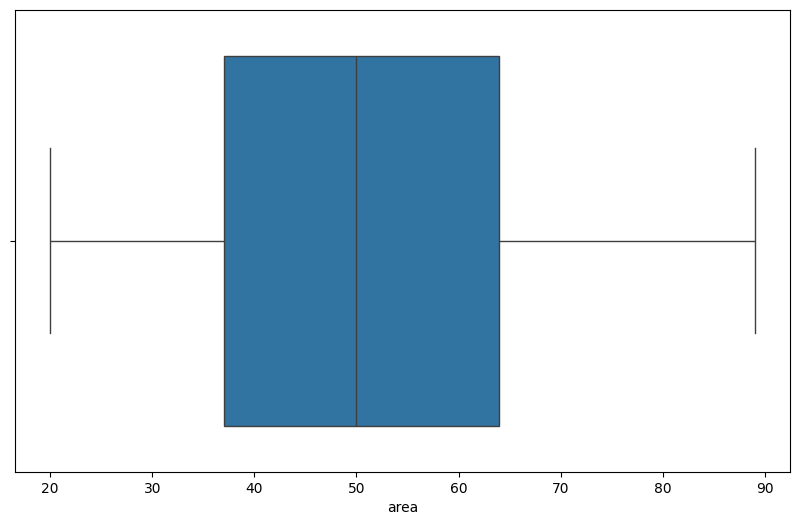

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])

#### Removendo imoveis sem quartos


In [13]:
df = df[df.bedrooms >= 1]
df.describe()

,area,bedrooms,garage,rent,total
count,8245.000000,8245.000000,8245.000000,8245.000000,8245.000000
mean,50.769436,1.598059,0.641601,2316.470467,2935.720558
std,17.055005,0.638598,0.644833,1394.657523,1724.806960
min,20.000000,1.000000,0.000000,500.000000,509.000000
25%,37.000000,1.000000,0.000000,1400.000000,1750.000000
50%,50.000000,2.000000,1.000000,2000.000000,2545.000000
75%,64.000000,2.000000,1.000000,2820.000000,3657.000000
max,89.000000,4.000000,5.000000,25000.000000,26710.000000


## Engenharia de Features


#### Removendo features que não serão utilizadas


In [14]:
df_clean = df.drop(columns=['rent','address'])

#### Criando coluna "price_m2"


In [15]:
df_clean["price_m2"] = df_clean["total"] / df_clean["area"]
df_clean.price_m2.describe()

count    8245.000000
mean       61.374726
std        37.250008
min         9.650000
25%        37.628571
50%        51.500000
75%        74.543210
max      1112.916667
Name: price_m2, dtype: float64

#### Criando coluna "price_level"


Foi utilizado dados a partir de uma pesquisa de mercado para entender os valores do m2 de alguel em SP, assim substituimos so valores dos quartis na nossa analise para os encotrados


In [16]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Medio", "Alto", "Muito Alto"]

df_clean["price_level"] = pd.cut(
    df_clean["price_m2"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

#### Distribuição de Imoveis Preço Total


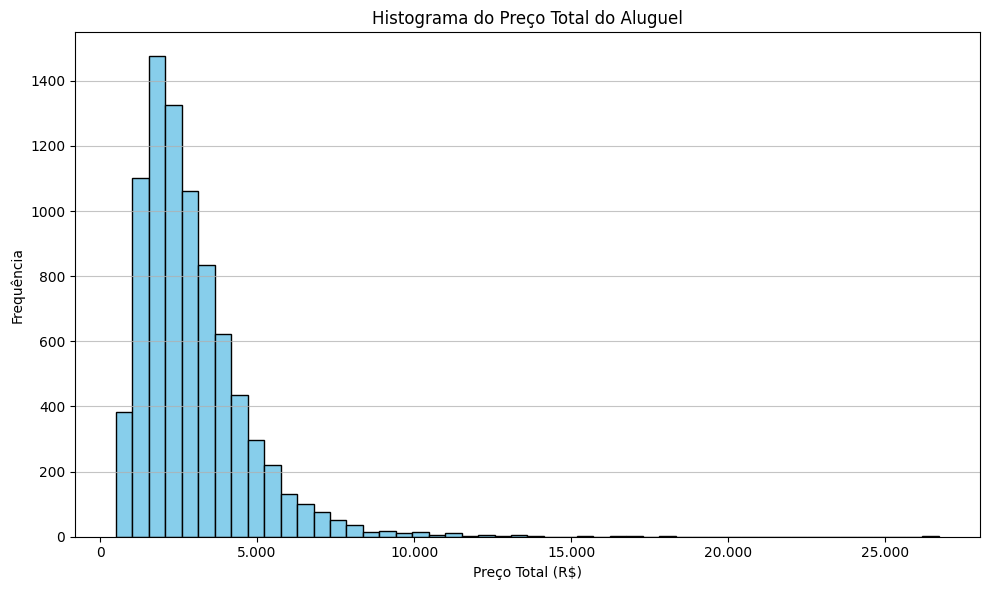

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['total'], bins=50, color='skyblue', edgecolor='black')

ax.set_title('Histograma do Preço Total do Aluguel')
ax.set_xlabel('Preço Total (R$)')
ax.set_ylabel('Frequência')
ax.grid(axis='y', alpha=0.75)

ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(",", "."))
)

plt.tight_layout()

#### Distribuição de Imoveis Preço m2


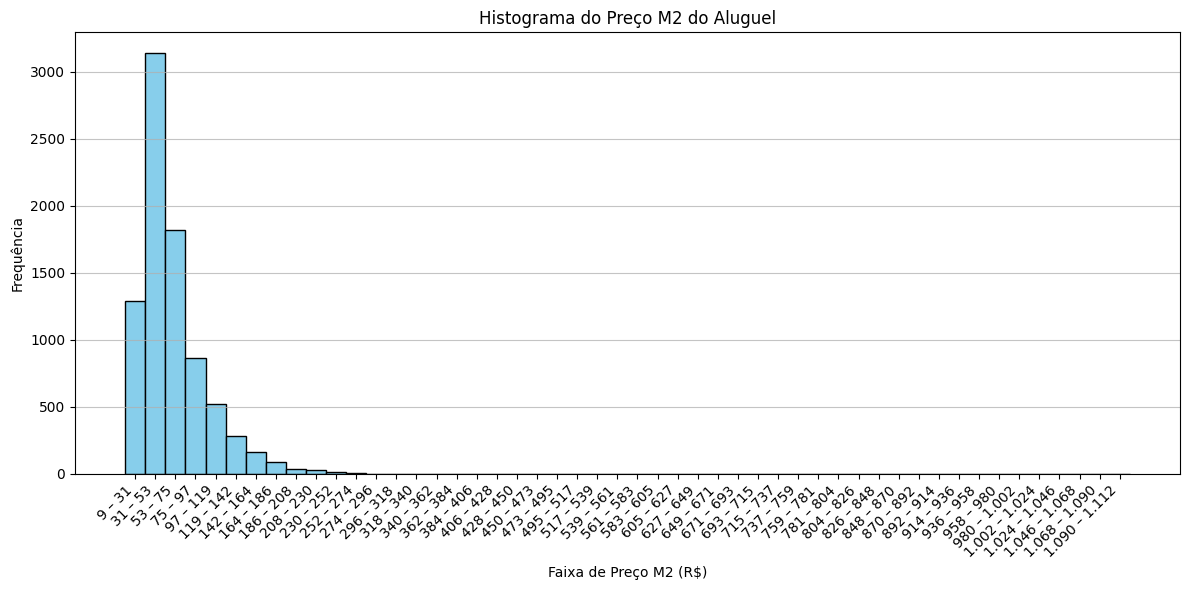

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

counts, bins, patches = ax.hist(
    df_clean['price_m2'], bins=50, color='skyblue', edgecolor='black'
)

bin_labels = [f"{int(bins[i]):,} – {int(bins[i+1]):,}".replace(",", ".")
              for i in range(len(bins)-1)]

bin_centers = (bins[:-1] + bins[1:]) / 2
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels, rotation=45, ha="right")

ax.set_title("Histograma do Preço M2 do Aluguel")
ax.set_xlabel("Faixa de Preço M2 (R$)")
ax.set_ylabel("Frequência")
ax.grid(axis="y", alpha=0.75)

plt.tight_layout()
plt.show()


#### Mapear bairros para cada faixa


In [19]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Médio", "Alto", "Muito Alto"]

df_clean["faixa_preco_m2"] = pd.cut(df_clean["price_m2"], bins=bins, labels=labels, include_lowest=True)

# Contagem de imóveis por distrito dentro de cada faixa
concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")

# Para cada faixa, pegar o distrito com maior concentração
top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]

top_distritos


/tmp/ipykernel_972511/2679612559.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")
/tmp/ipykernel_972511/2679612559.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]


,faixa_preco_m2,district,quantidade
17,Baixo,Bela Vista,88
1003,Médio,Bela Vista,78
1989,Alto,Bela Vista,61
3770,Muito Alto,Vila Mariana,92


#### Distribuição Bairro e Nível de Preço


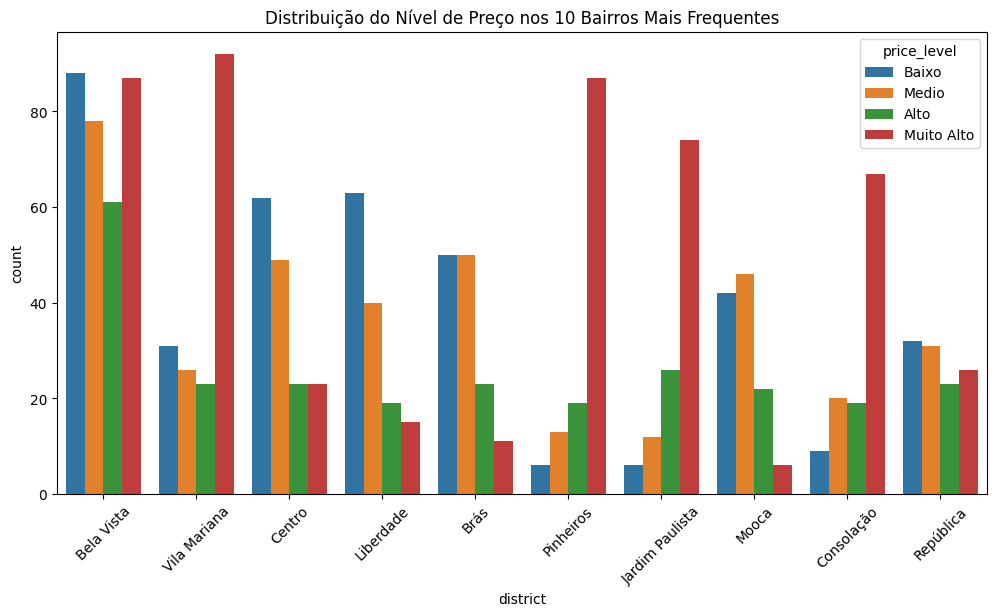

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='district', hue='price_level', order=df_clean['district'].value_counts().iloc[:10].index)
plt.title('Distribuição do Nível de Preço nos 10 Bairros Mais Frequentes')
plt.xticks(rotation=45)
plt.show()

#### Distribuição Tipo de Imóvel e Nível de Preço


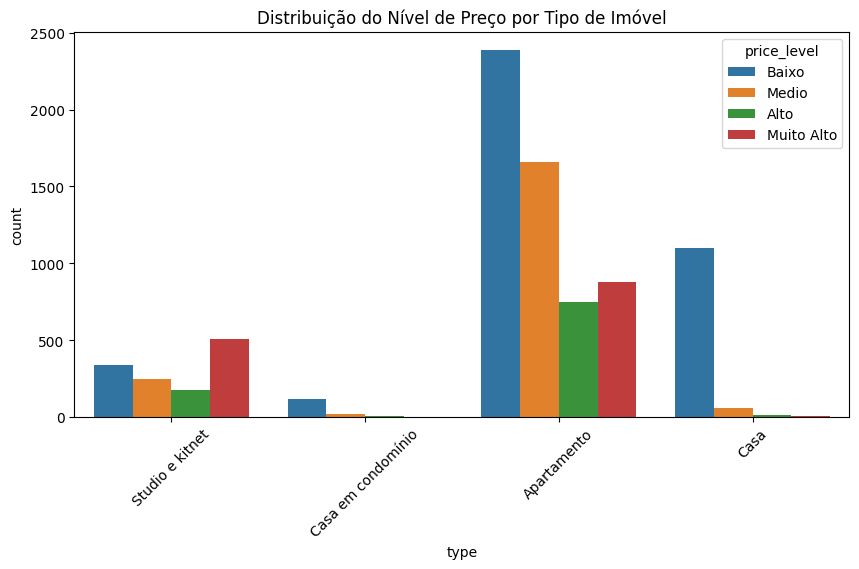

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='type', hue='price_level')
plt.title('Distribuição do Nível de Preço por Tipo de Imóvel')
plt.xticks(rotation=45)
plt.show()

### Correlação de Pearson


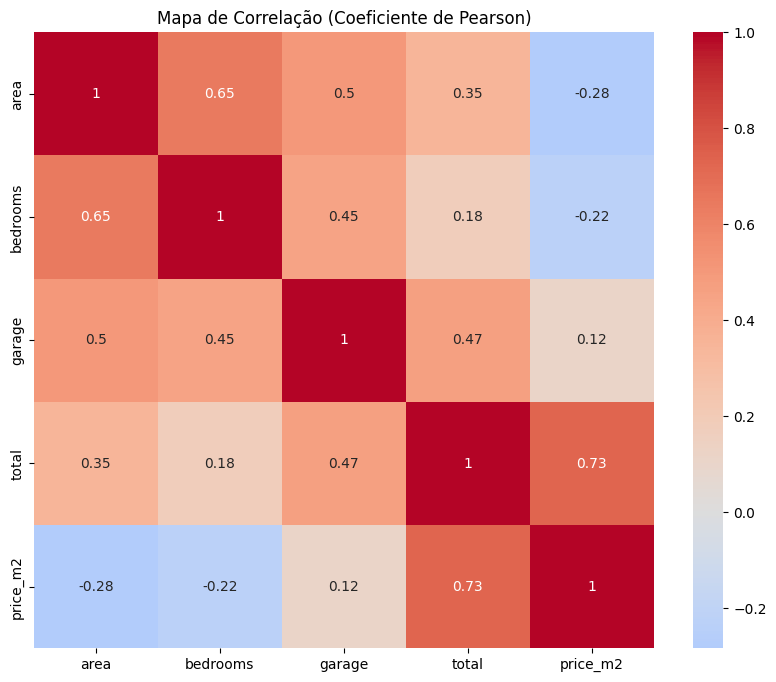

In [22]:
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()


#### Removendo linhas com NaN na feature target


In [23]:
df_clean.replace("?", np.nan, inplace=True)
df_clean = df_clean.dropna(subset=["price_level"])
df_clean

,district,area,bedrooms,garage,type,total,price_m2,price_level,faixa_preco_m2
0,Belenzinho,21,1,0,Studio e kitnet,2939,139.952381,Muito Alto,Muito Alto
3,Vila Ré,56,2,2,Casa em condomínio,1954,34.892857,Baixo,Baixo
5,Brás,50,2,1,Apartamento,4587,91.740000,Muito Alto,Muito Alto
6,Brooklin,72,2,1,Apartamento,5187,72.041667,Alto,Alto
7,Centro,26,1,0,Studio e kitnet,2244,86.307692,Alto,Alto
...,...,...,...,...,...,...,...,...,...
11638,Santo Amaro,70,2,1,Apartamento,4215,60.214286,Medio,Médio
11640,Jardim Caravelas,78,2,1,Apartamento,3686,47.256410,Baixo,Baixo
11645,Santo Amaro,70,2,0,Apartamento,3116,44.514286,Baixo,Baixo
11654,Jardim Caravelas,84,1,2,Apartamento,5467,65.083333,Medio,Médio


#### Distribuição Imoveis por Price_level


price_level
Baixo         3936
Medio         1981
Muito Alto    1390
Alto           938
Name: count, dtype: int64


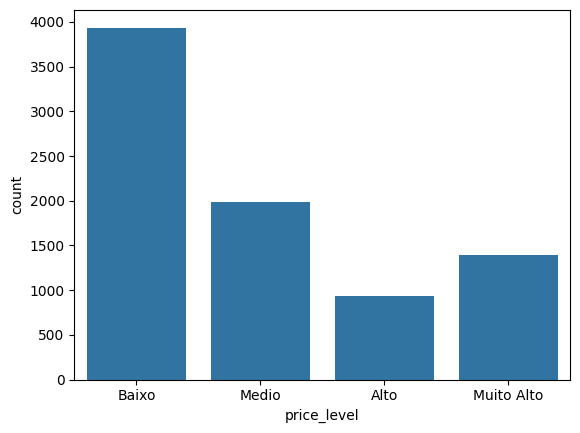

In [24]:
sns.countplot(x = df_clean['price_level'])
print(df_clean["price_level"].value_counts())

## Separação de Dados e Treinamento


#### Divisão entre previsores (X) e classe (y)


In [25]:
target = "price_level"
X = df_clean.drop(columns=[target, 'price_m2', 'total','faixa_preco_m2'])
y = df_clean[target]

print("Features utilizadas para o treinamento:", X.columns.tolist())

Features utilizadas para o treinamento: ['district', 'area', 'bedrooms', 'garage', 'type']


#### Separando variaveis entre numericas e categoricas


In [26]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

#### Escalonamento dos valores e Codificação de variáveis categóricas


In [27]:
ohe_enc = OneHotEncoder(sparse_output=False)
scaler_std = StandardScaler()

X_num_std = scaler_std.fit_transform(df[num_features])
X_nom = ohe_enc.fit_transform(df[cat_features]) if cat_features else np.empty((len(df),0))

X_final = np.hstack([X_num_std, X_nom])
X_final

array([[-1.74560142, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.30670651,  0.62944868,  2.10671926, ...,  0.        ,
         1.        ,  0.        ],
       [-0.0451177 ,  0.62944868,  0.5558353 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12762969,  0.62944868, -0.99504865, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.94855286, -0.93657557,  2.10671926, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47945391, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  0.        ]], shape=(8245, 993))

#### Divisão da Base em treinamento, teste


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

#### Transformer para converter sparse -> dense (para Naive Bayes)


In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X_final, y=None):
        return self
    def transform(self, X_final, y=None):
        return X_final.toarray()

#### Configurando modelos


In [30]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(),
    "NaiveBayes": GaussianNB()
}

#### Configurando Parametros

In [31]:
param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    }
}

In [32]:
resultados = []

#### Configurando treinamento

In [35]:
def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='grid', salvar_parametros=True):
    import time
    import joblib
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    from sklearn.utils.multiclass import unique_labels

    resultados = []

    # Variáveis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0

    # Aplicar balanceamento, se necessário
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necessário
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in models_default.items():
        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'Não'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        else:
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name] if tipo_parametros == "grid" else models_best_parameters[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )

        # Treinamento com medição de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previsões
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"✨ Novo melhor modelo encontrado: {descricao_cenario} com acurácia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes dinâmicas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusão - {descricao_cenario}')
        plt.show()

        # Relatório de classificação
        print(f"\nRelatório de Classificação para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": grid_search.best_params_ if tipo_parametros != "default" else "N/A"
            })
            # Salvar parâmetros
            if salvar_parametros and tipo_parametros != "default":
                joblib.dump(grid_search.best_params_, f'/home/llmdom/tes/dados/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": "N/A"
            })

        print("=" * 52)

    # Comparação final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acurácia Teste", ascending=False))

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'/home/llmdom/tes/dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"✨ Melhor modelo salvo: {nome_melhor_modelo} com acurácia de {melhor_score:.4f}!")

    # 🔑 RETORNA o melhor pipeline treinado
    return melhor_pipeline


Cenarios


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver 

✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: grid com acurácia de 0.6513!


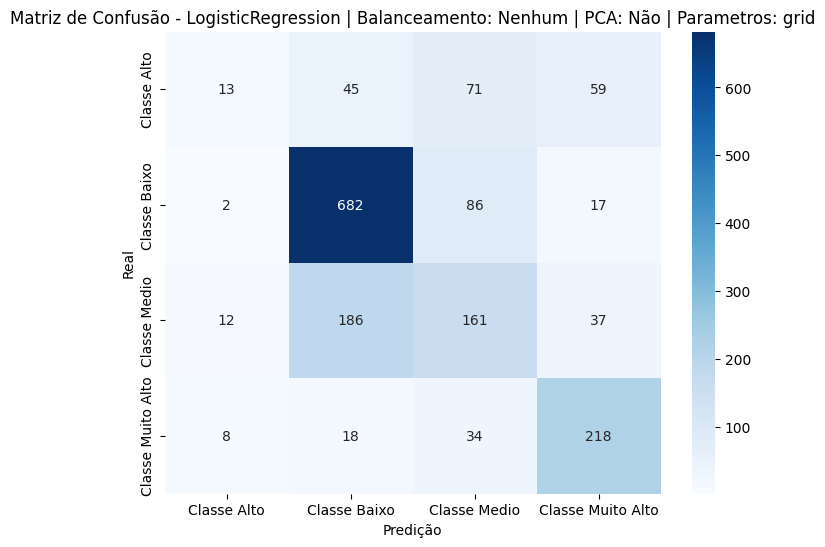


Relatório de Classificação para LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 7.7070 segundos

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits


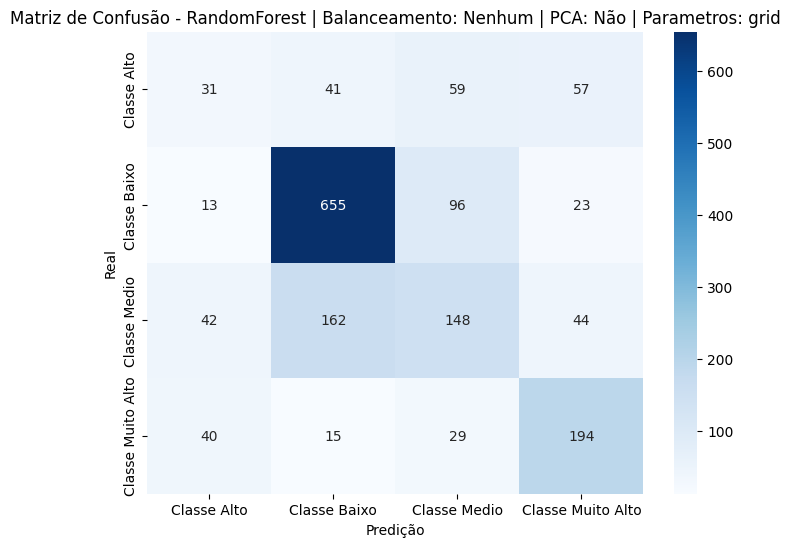


Relatório de Classificação para RandomForest | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.16      0.20       188
     Classe Baixo       0.75      0.83      0.79       787
     Classe Medio       0.45      0.37      0.41       396
Classe Muito Alto       0.61      0.70      0.65       278

         accuracy                           0.62      1649
        macro avg       0.51      0.52      0.51      1649
     weighted avg       0.60      0.62      0.61      1649

Tempo de treinamento: 23.9773 segundos

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


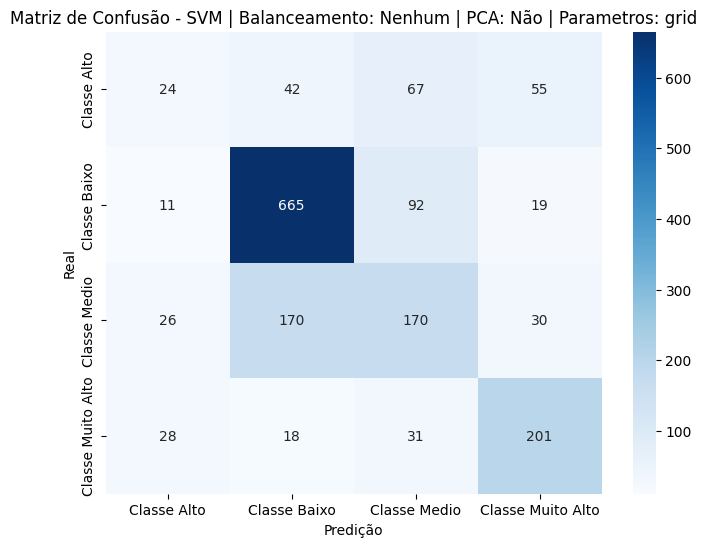


Relatório de Classificação para SVM | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 158.6269 segundos

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_sc

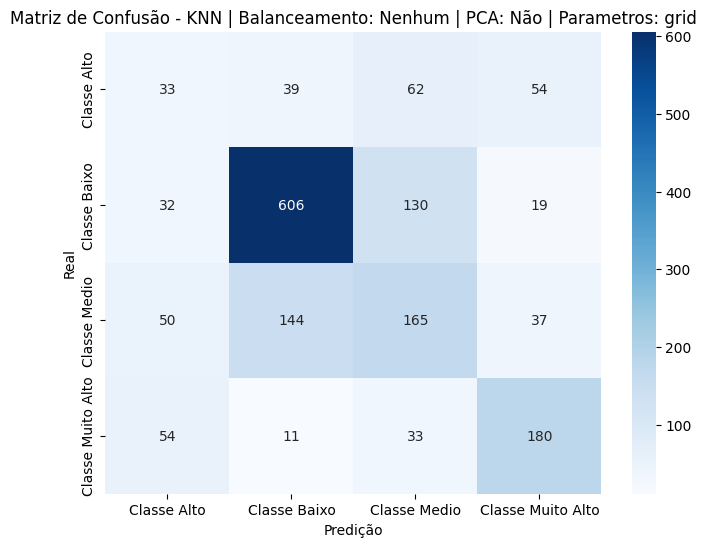


Relatório de Classificação para KNN | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.76       787
     Classe Medio       0.42      0.42      0.42       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.59      1649

Tempo de treinamento: 6.5756 segundos

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


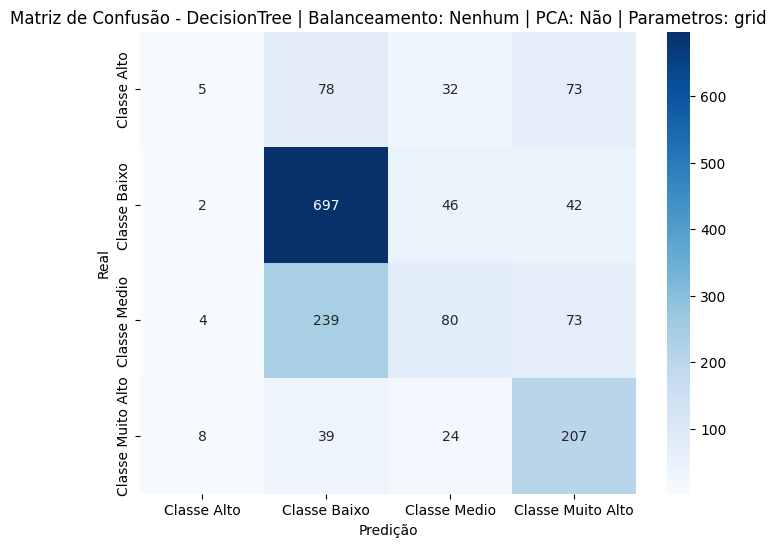


Relatório de Classificação para DecisionTree | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.89      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 1.0234 segundos

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Example usage of the treinar_modelos function
scenarios = []

# Default Parameters
scenarios.append(("default", treinar_modelos()))
scenarios.append(("default + SMOTE", treinar_modelos(balanceamento="smote")))
scenarios.append(("default + Tomek", treinar_modelos(balanceamento="tomek")))
scenarios.append(("default + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True)))
scenarios.append(("default + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True)))

# GridSearch
scenarios.append(("grid", treinar_modelos(tipo_parametros="grid")))
scenarios.append(("grid + SMOTE", treinar_modelos(balanceamento="smote", tipo_parametros="grid")))
scenarios.append(("grid + Tomek", treinar_modelos(balanceamento="tomek", tipo_parametros="grid")))
scenarios.append(("grid + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True, tipo_parametros="grid")))
scenarios.append(("grid + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True, tipo_parametros="grid")))

# Best Parameters
scenarios.append(("best", treinar_modelos(tipo_parametros="best")))
scenarios.append(("best + SMOTE", treinar_modelos(balanceamento="smote", tipo_parametros="best")))
scenarios.append(("best + Tomek", treinar_modelos(balanceamento="tomek", tipo_parametros="best")))
scenarios.append(("best + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True, tipo_parametros="best")))
scenarios.append(("best + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True, tipo_parametros="best")))

# Iterate through scenarios and evaluate
for name, pipeline in scenarios:
    print(f"Evaluating scenario: {name}")
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"Score for {name}: {score}")